# Tarea 3: PINNs, Redes Recurrentes y Transformers

En esta Tarea Trabajaremos Con [Pytorch](https://pytorch.org/), una librería de Deep Learning de código abierto desarrollada por Facebook. Pytorch es una librería de Deep Learning que se basa en el concepto de [Tensores](https://pytorch.org/docs/stable/tensors.html), que son similares a los arreglos de Numpy, pero con la diferencia de que pueden ser utilizados en una GPU para acelerar los cálculos.

Se escogio Pytorch por sobre Tensorflow o Keras ya que tiene un paquete de [diferenciacion automatica](https://pytorch.org/docs/stable/autograd.html) que nos permite calcular derivadas de forma automatica, lo que nos permite implementar de forma sencilla los modelos de redes neuronales y sobre todo trabajar con PINNs y modificar pequeños detalles de forma sencilla en el lopp de entrenamiento como lo es aplicar custom losses, etc.

Dado que la ultima seccion del curso esta enfocado a trabajar con series temporales, todos los problemas en esta tarea de alguna u otra forma estan relacionados con series temporales o secuencias.

# 1. Imports

In [1]:
#data
import numpy as np
import pandas  as pd

# torch
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)

In [ ]:
device

'cuda'

En esta tarea tenemos 2 Secciones obligatorias, la parte de Redes Recurrentes y la Parte de Transformers, pero como no hay desafio Kaggle se añadio una seccion extra sobre PINNS (Physics Informed Neural Networks) la cual es opcional y sirve como bonus para la nota final.

Dado que no hay desafio Kaggle se incentiva a ser creativos y modificar los codigos, esto tambien añadira un bonus para la tarea.

# Parte 2: Redes Recurrentes

En esta tarea no hay desafio kaggle, por lo que en esta seccion deberan utilizar su creatividad para resolver un problema de series temporales, utilizando redes recurrentes.

## 2.1 Cargar Datos

In [ ]:
import zipfile
import os

# Ruta del archivo .zip que deseas descomprimir (asegúrate de que esté en la ubicación correcta)
file_path = '/content/Datos.zip'  # Cambia '/content/archivo.zip' por la ruta de tu archivo .zip

# Directorio de destino para la extracción
extracted_dir = '/content/'  # Cambia '/content/directorio_extraido' por la ruta de tu directorio destino

# Descomprimir el archivo .zip
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Listar los archivos extraídos (opcional)
extracted_files = os.listdir(extracted_dir)
print("Archivos extraídos:", extracted_files)

Archivos extraídos: ['.config', 'data', 'img', 'Datos.zip', 'sample_data']


In [ ]:
train_df = pd.read_csv('data/DailyClimate_Train.csv')
test_df = pd.read_csv('data/DailyClimate_test.csv')

## 2.2 EDA & data Viz

En esta seccion deberan realizar un analisis exploratorio de los datos, generar visualizaciones que les permitan entender mejor los datos con los que estan trabajando y sacar conclusiones de estos.

In [ ]:
### Start code here ###
train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [ ]:
print(train_df.columns)
print(test_df.columns)

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')
Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')


<ipython-input-10-9f902eab45be>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


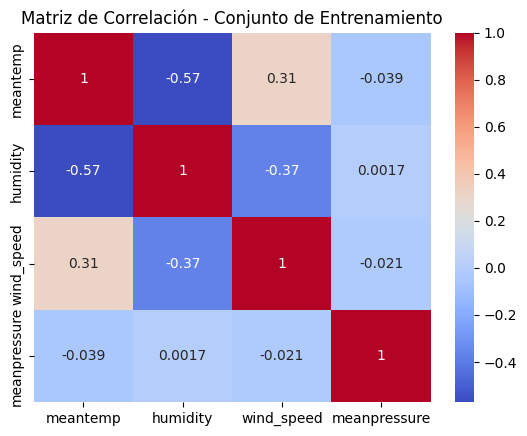

In [ ]:
# Correlación entre las variables en el conjunto de datos de entrenamiento
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación - Conjunto de Entrenamiento')
plt.show()

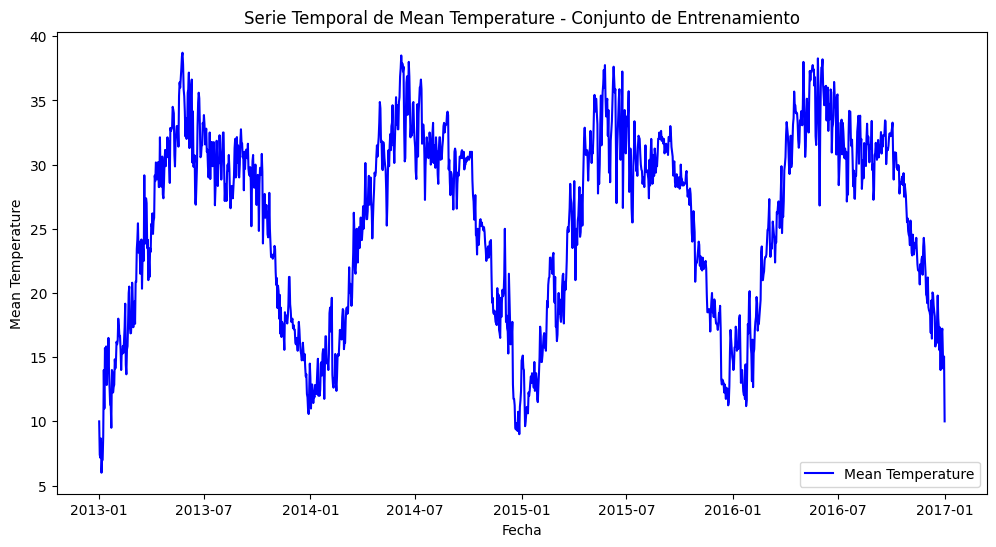

In [ ]:
#Graficos de ejemplo
# Convertir la columna 'date' a tipo datetime si no está en ese formato
aux_date = pd.to_datetime(train_df['date'])

# Visualización de la serie temporal de 'meantemp' en el conjunto de entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(aux_date, train_df['meantemp'], label='Mean Temperature', color='blue')
plt.title('Serie Temporal de Mean Temperature - Conjunto de Entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()


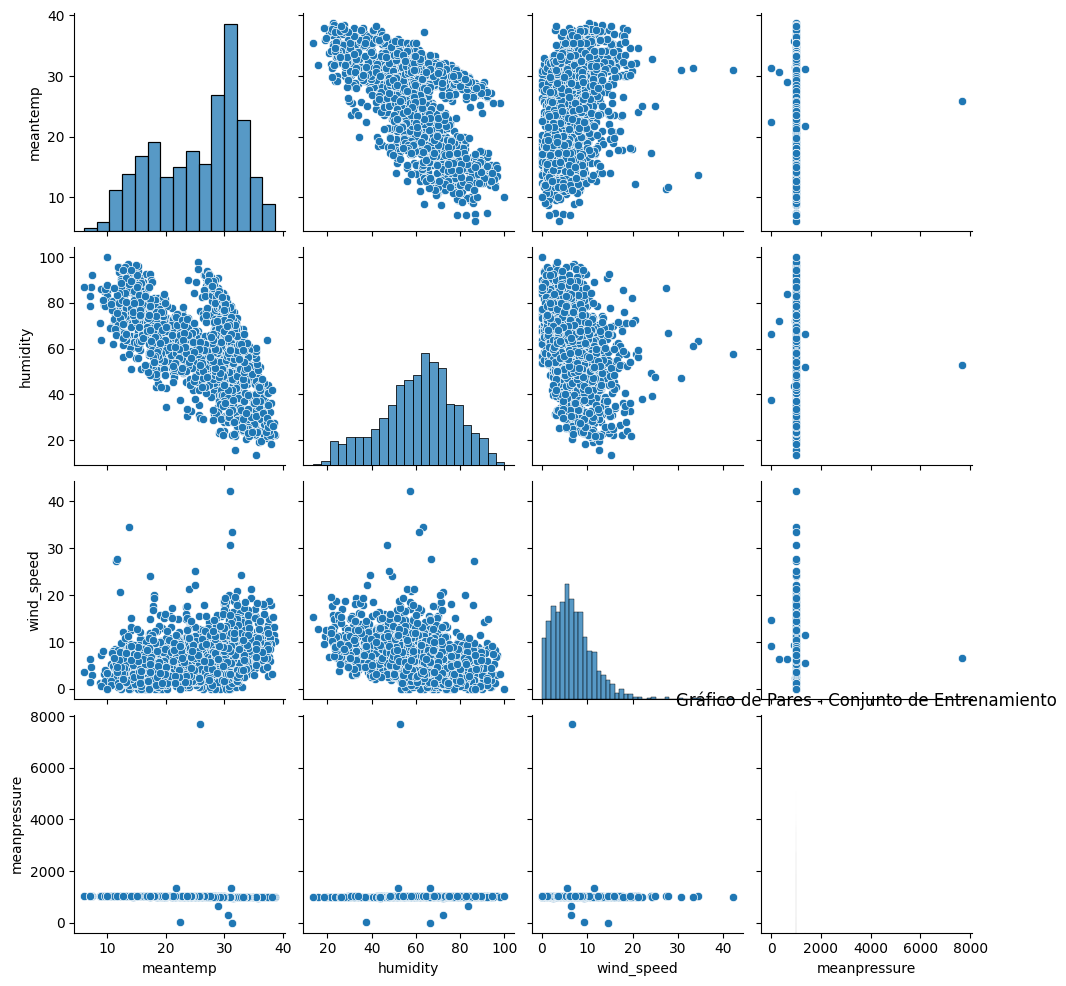

In [ ]:
# Visualización de otras variables en el conjunto de entrenamiento
sns.pairplot(train_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])
plt.title('Gráfico de Pares - Conjunto de Entrenamiento')
plt.show()

In [ ]:
# Filtrar datos con y sin outliers en 'meanpressure'
outlier_value = train_df['meanpressure'].quantile(0.9995)  # Establecer un umbral para identificar outliers
data_with_outlier = train_df[train_df['meanpressure'] > outlier_value]
data_without_outlier = train_df[train_df['meanpressure'] <= outlier_value]

print("Outlier threshold for meanpressure:", outlier_value)
print("Number of outliers reached:", data_with_outlier.count())
data_with_outlier

Outlier threshold for meanpressure: 3057.6658717955506
Number of outliers reached: date            1
meantemp        1
humidity        1
wind_speed      1
meanpressure    1
dtype: int64


,date,meantemp,humidity,wind_speed,meanpressure
1182,2016-03-28,25.933333,52.8,6.546667,7679.333333


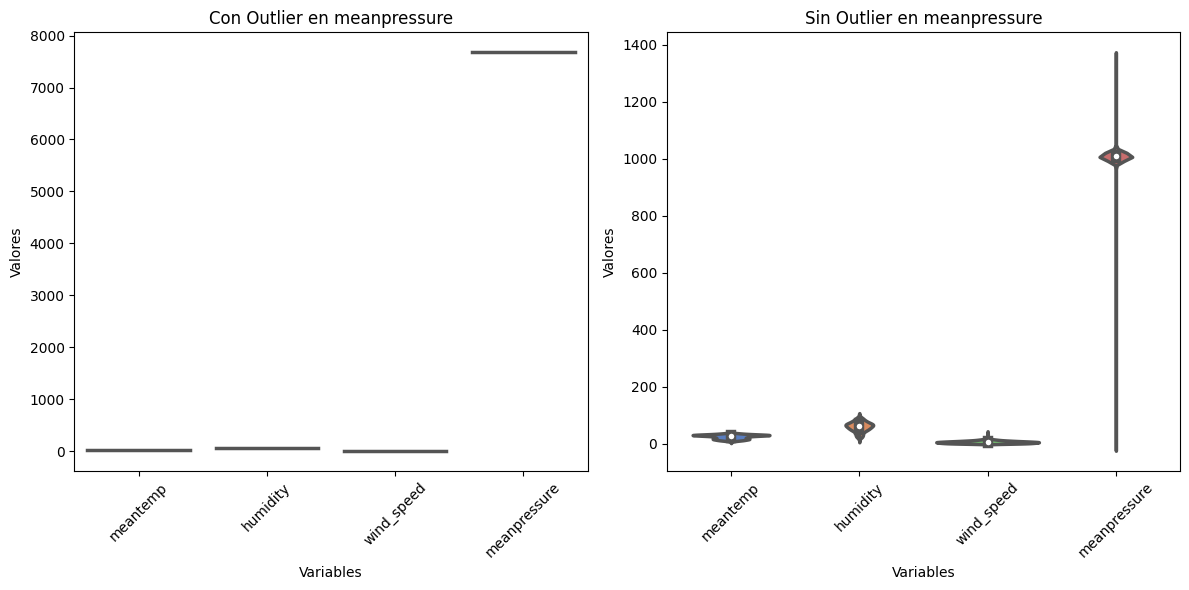

In [ ]:
# Visualización con outlier en 'meanpressure'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.violinplot(data=data_with_outlier[['meantemp', 'humidity', 'wind_speed', 'meanpressure']], palette='muted', linewidth=2.5)
plt.title('Con Outlier en meanpressure')
plt.xlabel('Variables')
plt.ylabel('Valores')
plt.xticks(rotation=45)

# Visualización sin outlier en 'meanpressure'
plt.subplot(1, 2, 2)
sns.violinplot(data=data_without_outlier[['meantemp', 'humidity', 'wind_speed', 'meanpressure']], palette='muted', linewidth=2.5)
plt.title('Sin Outlier en meanpressure')
plt.xlabel('Variables')
plt.ylabel('Valores')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 2.3 Preprocesamiento

En esta seccion deberan aplicar las transformaciones necesarias a los datos para poder entrenar su modelo, crear columnas, eliminar columnas, escalar los datos, etc.

In [ ]:
### Start Code Here ###

def create_cyclic_cols(df, col_name):

  if col_name in df.columns:
    # Create the new cyclic columns
    df['sin_' + col_name] = np.sin(2 * np.pi * df[col_name] / max(df[col_name]))
    df['cos_' + col_name] = np.cos(2 * np.pi * df[col_name] / max(df[col_name]))

    # Delete the column of which we made the cyclic ones
    df.drop(columns = [col_name], inplace = True)

In [ ]:
# Convert the column 'date' in datetime type
train_df['date'] = pd.to_datetime(train_df['date'])

# Split the date in day, month and year
train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year

train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure,day,month,year
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,1,2013
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2,1,2013
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,3,1,2013
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,4,1,2013
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,5,1,2013


In [ ]:
# Convert the column 'date' in datetime type
test_df['date'] = pd.to_datetime(test_df['date'])

# Split the date in day, month and year
test_df['day'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month
test_df['year'] = test_df['date'].dt.year

test_df.head()

,date,meantemp,humidity,wind_speed,meanpressure,day,month,year
0,2017-01-01,15.913043,85.869565,2.743478,59.000000,1,1,2017
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778,2,1,2017
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333,3,1,2017
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000,4,1,2017
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333,5,1,2017


In [ ]:
create_cyclic_cols(train_df, 'day')
create_cyclic_cols(train_df, 'month')

# train_df.drop(columns = ['date'], inplace = True)
train_df.drop(columns = ['date', 'sin_day', 'cos_day'], inplace = True)

train_df.head()

,meantemp,humidity,wind_speed,meanpressure,year,sin_month,cos_month
0,10.000000,84.500000,0.000000,1015.666667,2013,0.5,0.866025
1,7.400000,92.000000,2.980000,1017.800000,2013,0.5,0.866025
2,7.166667,87.000000,4.633333,1018.666667,2013,0.5,0.866025
3,8.666667,71.333333,1.233333,1017.166667,2013,0.5,0.866025
4,6.000000,86.833333,3.700000,1016.500000,2013,0.5,0.866025


In [ ]:
create_cyclic_cols(test_df, 'day')
create_cyclic_cols(test_df, 'month')

test_df.drop(columns = ['date', 'sin_day', 'cos_day'], inplace = True)

test_df.head()

,meantemp,humidity,wind_speed,meanpressure,year,sin_month,cos_month
0,15.913043,85.869565,2.743478,59.000000,2017,1.0,6.123234e-17
1,18.500000,77.222222,2.894444,1018.277778,2017,1.0,6.123234e-17
2,17.111111,81.888889,4.016667,1018.333333,2017,1.0,6.123234e-17
3,18.700000,70.050000,4.545000,1015.700000,2017,1.0,6.123234e-17
4,18.388889,74.944444,3.300000,1014.333333,2017,1.0,6.123234e-17


In [ ]:
def plot_cyclic_variable(df, variable_name):

  # Verificar si la variable cíclica está presente en el DataFrame
  if f'sin_{variable_name}' not in df.columns or f'cos_{variable_name}' not in df.columns:
      print(f"Las columnas 'sin_{variable_name}' o 'cos_{variable_name}' no están presentes en el DataFrame.")
      return

  # Obtener las columnas sin y cos asociadas a la variable cíclica
  sin_column = f'sin_{variable_name}'
  cos_column = f'cos_{variable_name}'

  # Calcular el ángulo theta utilizando arcotangente
  theta = np.arctan2(df[sin_column], df[cos_column])

  # Crear el gráfico de dispersión polar
  plt.figure(figsize=(4, 4))
  plt.polar(theta, np.ones_like(theta), 'ro')  # 'ro' significa puntos rojos
  plt.title(f'Cyclic Variable: {variable_name}')
  plt.show()

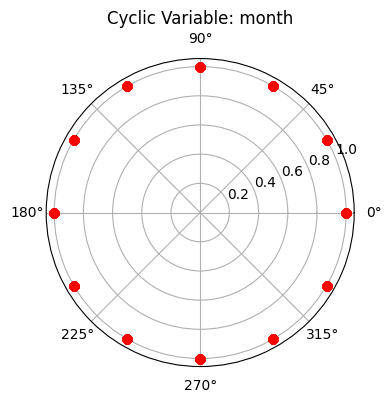

In [ ]:
# Graficamos las variables day y month del conjunto de train y del de test
# plot_cyclic_variable(train_df, 'day')
plot_cyclic_variable(train_df, 'month')

# plot_cyclic_variable(test_df, 'day')
# plot_cyclic_variable(test_df, 'month')

In [ ]:
test_df['sin_month'].value_counts()

 1.000000e+00    31
-1.000000e+00    31
 1.224647e-16    28
-2.449294e-16    24
Name: sin_month, dtype: int64

In [ ]:
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure,year,sin_month,cos_month
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1.462000e+03,1.462000e+03
mean,25.495521,60.771702,6.802209,1011.104548,2014.502736,-4.439385e-03,-1.435073e-03
std,7.348103,16.769652,4.561602,180.231668,1.120248,7.058818e-01,7.087973e-01
min,6.000000,13.428571,0.000000,-3.041667,2013.000000,-1.000000e+00,-1.000000e+00
25%,18.857143,50.375000,3.475000,1001.580357,2014.000000,-8.660254e-01,-8.660254e-01
50%,27.714286,62.625000,6.221667,1008.563492,2015.000000,-2.449294e-16,-1.836970e-16
75%,31.305804,72.218750,9.238235,1014.944901,2016.000000,5.000000e-01,8.660254e-01
max,38.714286,100.000000,42.220000,7679.333333,2017.000000,1.000000e+00,1.000000e+00


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize the non-cyclic columns with StandardScaler
def normalize_columns(columns_to_normalize):

    # Create instance of scaler
    scaler = StandardScaler()

    # Normalize the columns specified
    train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
    test_df[columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])

columns_to_normalize = ['humidity', 'wind_speed', 'meanpressure', 'year']
normalize_columns(columns_to_normalize)

In [ ]:
test_df.describe()

,meantemp,humidity,wind_speed,meanpressure,year,sin_month,cos_month
count,114.000000,114.000000,114.000000,114.000000,1.140000e+02,1.140000e+02,1.140000e+02
mean,21.713079,-0.269229,0.294233,-0.039238,2.229970e+00,-5.104324e-17,-3.508772e-02
std,6.360072,1.137448,0.786846,0.496613,4.460499e-16,7.407244e-01,6.774474e-01
min,11.000000,-2.566328,-1.187425,-5.284478,2.229970e+00,-1.000000e+00,-1.000000e+00
25%,16.437198,-1.261442,-0.271635,-0.020353,2.229970e+00,-1.000000e+00,-1.836970e-16
50%,19.875000,-0.180250,0.277900,0.009073,2.229970e+00,1.224647e-16,-1.836970e-16
75%,27.705357,0.663990,0.716340,0.031276,2.229970e+00,1.000000e+00,6.123234e-17
max,34.500000,2.091494,2.743851,0.064966,2.229970e+00,1.000000e+00,1.000000e+00


In [ ]:
print(train_df.columns)
print(test_df.columns)

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'year',
       'sin_month', 'cos_month'],
      dtype='object')
Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'year',
       'sin_month', 'cos_month'],
      dtype='object')


In [ ]:
objective_col = 'meantemp' # columna objetivo
# selected_cols = ['humidity', 'wind_speed', 'meanpressure', 'year', 'sin_day',
#        'cos_day', 'sin_month', 'cos_month']  # lista de columnas seleccionadas para entrenar
selected_cols = ['humidity', 'wind_speed', 'meanpressure', 'year', 'sin_month', 'cos_month']  # lista de columnas seleccionadas para entrenar

In [ ]:
# En este ejemplo nos quedamos solo con las columnas numericas, pero la idea es que en la lista anterior se incluyan las columnas que se quieran usar para entrenar el modelo, columnas nuevas que hayan creado o modificado en el preprocesamiento.
selected_cols = train_df.drop(columns=objective_col).select_dtypes(include='number').columns.tolist() #solo ejecutar a modo de ejemplo

In [ ]:
# IMPORTANTE: agregamos la columna objetivo al final de la lista, deben asegurarse de que este al final para el correcto funcionamiento del codigo
selected_cols.append(objective_col)
selected_cols

['humidity',
 'wind_speed',
 'meanpressure',
 'year',
 'sin_month',
 'cos_month',
 'meantemp']

In [ ]:
tr_timeseries = train_df[selected_cols].values.astype('float32')
te_timeseries = test_df[selected_cols].values.astype('float32')

In [ ]:
# concatenamos los dataframes para despues hacer las visualizaciones, No borrar ni modificar
new = pd.concat([train_df, test_df], axis=0).reset_index().drop('index', axis=1)
new_timeseries = new[selected_cols].values.astype('float32')
shape = new_timeseries.shape[1]

## 2.4 Dataset y DataLoader

In [ ]:
def create_dataset(dataset, lookback, shape):
    """Funcion para crear los tensores de entrenamiento y test
    dataset: np.ndarray
    lookback: int (numero de dias a considerar o largo de la secuencia)
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,:shape-1][i:i+lookback]
        target = dataset[:, shape-1][i:i+lookback]
        X.append(feature)
        y.append(target)
    # Convierte las listas a np.ndarray antes de convertirlas en tensores
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
lookback = 7 #consideraremos los ultimos 7 dias para predecir el dia siguiente

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback, shape=shape)
X_test, y_test = create_dataset(test, lookback=lookback, shape=shape)

In [ ]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size = 8, shuffle = True) #dataloader para entrenar los modelos de Pytorch

## 2.5 Modelo Recurrente

En esta seccion se implementa uan clase base para modelos recurrentes, pueden utilizar esta clase o pueden modificarla o crear una nueva clase si lo desean, recuerden que hay bonus por creatividad en esta tarea.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional, rnn_class):
        super().__init__()
        # Verificar que rnn_class es una de las clases de RNN permitidas
        if rnn_class not in [nn.LSTM, nn.GRU, nn.RNN]:
            raise ValueError("rnn_class must be nn.LSTM, nn.GRU, or nn.RNN")

        # Inicializar la capa recurrente con la clase pasada como parámetro
        self.rnn = rnn_class(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=bidirectional)

        # Calcular la dimensión de salida de la capa recurrente
        # Es doble si es bidireccional
        factor = 2 if bidirectional else 1

        self.dropout = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(hidden_size * factor, 64)
        self.linear2 = nn.Linear(64, 32)
        self.output_linear = nn.Linear(32, 1)

    def forward(self, x):
        # LSTM devuelve (output, (h_n, c_n)) mientras que GRU y RNN solo devuelve (output, h_n)
        x, _ = self.rnn(x)
        x = self.dropout(x) # Aplicar dropout
        x = self.linear1(x) # Aplicar linear1
        x = self.linear2(x) # Aplicar linear2
        x = self.output_linear(x) # Aplicar output_linear
        return x

## 2.6 Hiperparámetros

Aca pueden variar los hiperparametros de la red recurrente, pueden agregar mas si lo desean, para mas informacion sobre los optimizadores pueden revisar la documentacion de [pytorch Optim](https://pytorch.org/docs/stable/optim.html), y para mas informacion sobre los criterios de perdida pueden revisar la documentacion de [pytorch Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
# Hiperparametros del modelo
input_size = shape-1
hidden_size = 64
num_layers = 3
dropout = 0.1
bidirectional = True # puede ser True o False
layer_type = nn.RNN # puede ser nn.RNN, nn.LSTM o nn.GRU

# Modelo
model = RNNModel(input_size, hidden_size, num_layers, dropout, bidirectional, layer_type)

#optimizador
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# loss func: MSE
loss_fn = nn.MSELoss()

## 2.7 Funciones de entrenamiento y evaluacion

En esta seccion se implementan funciones que nos ayudaran a entrenar y evaluar nuestro modelo, Pytorch no implementa metodos como .fit() por ende los tenemos que crear desde cero, al igual que antes sientanse libres de modificar o crear nuevas funciones, para mas informacion sobre el training loop pueden revisar la documentacion de [pytorch Custom Training](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#custom-training-loop)

In [ ]:
class CustomEarlyStopping:
    """
    Funcion para detener el entrenamiento cuando la loss de validacion no mejora
    """
    def __init__(self, patience=20, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None

    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0

In [ ]:
def train_model(model, optimizer, early_stopping):
    """
    Funcion para entrenar el modelo
    """
    best_score = None
    best_weights = None

    n_epochs = 200

    for epoch in range(n_epochs):
        model.train() # Entrenamiento
        for X_batch, y_batch in loader:
            optimizer.zero_grad() # Zero gradients
            y_pred = model(X_batch) # Forward pass
            loss = loss_fn(y_pred, y_batch.unsqueeze(2)) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights

        model.eval() # Validacion
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train.unsqueeze(2)))

            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test.unsqueeze(2)))

            if best_score is None or test_rmse < best_score:
                best_score = test_rmse
                best_weights = model.state_dict()

            early_stopping(test_rmse, model, X_test)

            # Check if early stopping criterion is met
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if epoch % 10 == 0:
            print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', train_rmse, '\ test RMSE', test_rmse)

    return model, best_weights

In [ ]:
def get_preds(model, best_weights):
    """
    Funcion para obtener las predicciones y desnormalizarlas
    """
    # Usamos los mejores pesos para hacer las predicciones
    if best_weights is not None:
        model.load_state_dict(best_weights)

        # Calculamos las predicciones
        with torch.no_grad():
            y_pred_train = model(X_train).clone().detach().cpu().numpy()
            y_pred_test = model(X_test).clone().detach().cpu().numpy()

        # Modificamos las dimensiones de las predicciones para luego graficarlas
        with torch.no_grad():
            train_predictions = np.ones_like(new_timeseries) * np.nan
            train_predictions[lookback: len(train)] = y_pred_train[:,-1,:]

            test_predictions = np.ones_like(new_timeseries) * np.nan
            test_predictions[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

        return train_predictions, test_predictions

In [ ]:
def plot_predictions(train_predictions, test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """
    # plot
    plt.figure(figsize=(20,10))
    plt.plot(new_timeseries[:,shape-1], c = 'b', label = 'True')
    plt.plot(train_predictions[:,shape-1], c='r', label = 'Train')
    plt.plot(test_predictions[:,shape-1], c='g', label = 'Test')
    plt.legend()
    plt.show()

In [ ]:
def plot_eval(test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """

    eval_df = pd.concat([test_df['meantemp'].reset_index(),pd.Series(test_predictions[:,shape-1][len(train):].reshape(-1).tolist())],axis=1).drop('index',axis=1) #creamos un dataframe con las predicciones y los valores reales

    eval_df.columns = ['real_meantemp', 'pred_meantemp'] #renombramos las columnas

    rmse = np.sqrt(mean_squared_error(eval_df.iloc[7:]['real_meantemp'], eval_df.iloc[7:]['pred_meantemp'])) #calculamos el rmse

    print(f'RMSE: {rmse}')

    fig = go.Figure(data = [
        go.Scatter(x = eval_df.index, y = eval_df['real_meantemp'], mode='lines', name = "Actual"),
        go.Scatter(x = eval_df.index, y = eval_df['pred_meantemp'], mode='lines', name="Predicted"),
    ])

    fig.update_layout(
        font = dict(size=17, family="Franklin Gothic"),
        template = 'simple_white',
        title = 'Real & Predicted Temperature'
    )

    fig.show()

## 2.8 Entrenamiento

In [ ]:
early_stopping = CustomEarlyStopping(patience=15, verbose=True)
model, model_best_weights = train_model(model, optimizer, early_stopping)

********** Epoch:  0 \ train RMSE:  tensor(3.7566) \ test RMSE tensor(9.0858)
EarlyStopping counter: 1 out of 15, score: -9.085793495178223
EarlyStopping counter: 2 out of 15, score: -9.085793495178223
EarlyStopping counter: 3 out of 15, score: -9.085793495178223
EarlyStopping counter: 4 out of 15, score: -9.085793495178223
EarlyStopping counter: 5 out of 15, score: -9.085793495178223
EarlyStopping counter: 6 out of 15, score: -9.085793495178223
EarlyStopping counter: 7 out of 15, score: -9.085793495178223
EarlyStopping counter: 1 out of 15, score: -9.084214210510254
EarlyStopping counter: 2 out of 15, score: -9.084214210510254
********** Epoch:  10 \ train RMSE:  tensor(2.1219) \ test RMSE tensor(10.9220)
EarlyStopping counter: 3 out of 15, score: -9.084214210510254
EarlyStopping counter: 4 out of 15, score: -9.084214210510254
EarlyStopping counter: 5 out of 15, score: -9.084214210510254
EarlyStopping counter: 6 out of 15, score: -9.084214210510254
EarlyStopping counter: 7 out of 15, 

In [ ]:
train_predictions, test_predictions = get_preds(model, model_best_weights)

## 2.9 Evaluacion

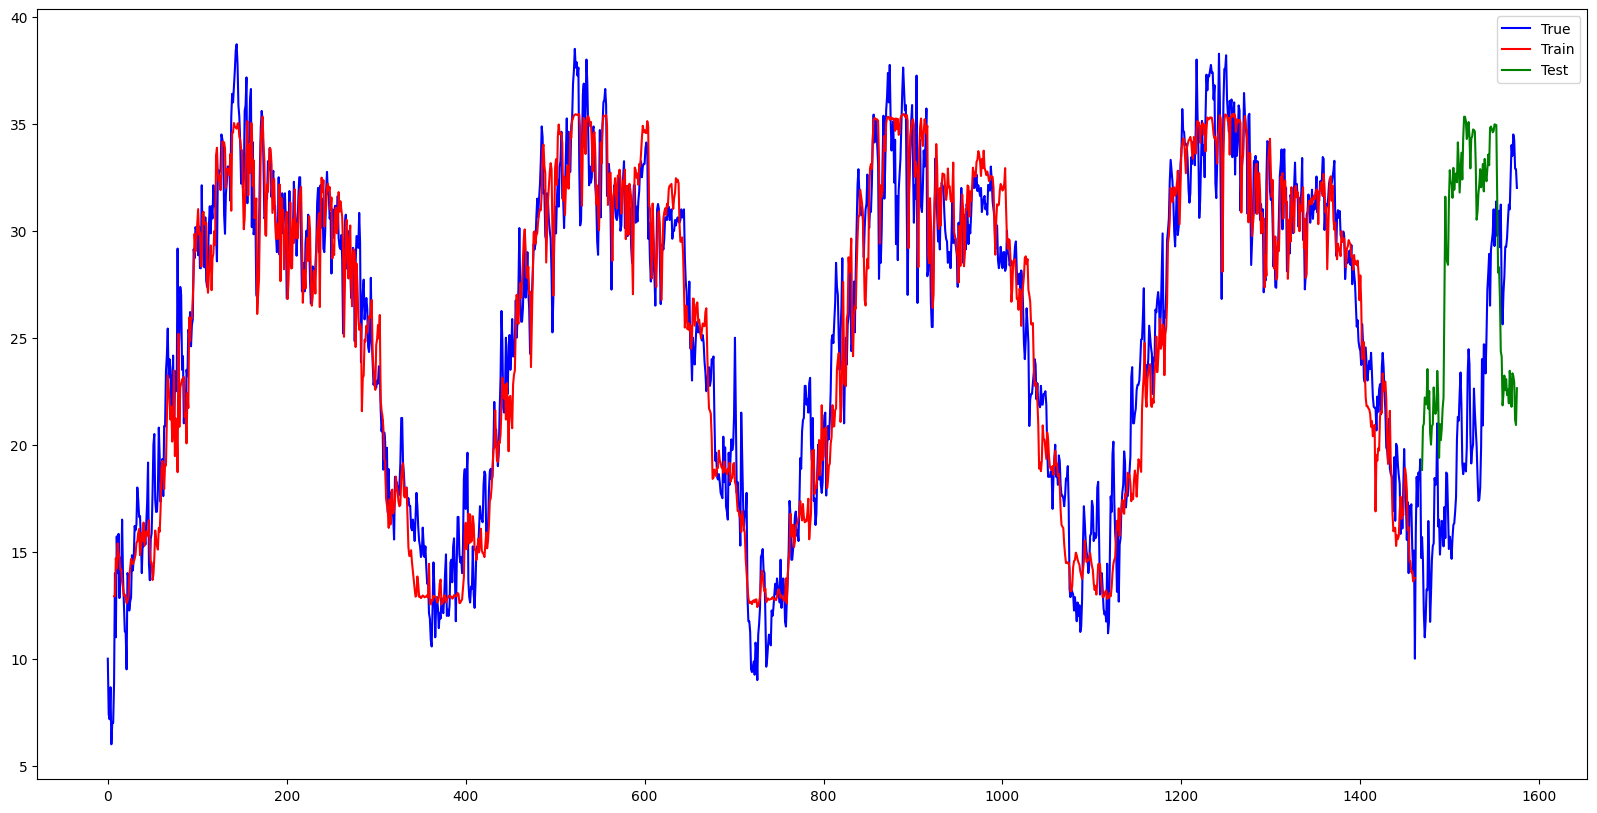

In [ ]:
plot_predictions(train_predictions, test_predictions, shape)

In [ ]:
plot_eval(test_predictions, shape)

RMSE: 10.298348912559074


# Parte 3: Transformers

Para esta parte vamos a entrenar un transformer muy simple para que aprenda a generar texto como el del Quijote.

In [ ]:
#Vamos a importar el archivo de texto que tenemos en google drive, para eso vamos a importar las librerias relevantes

#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Aqui se importa el dataset desde google drive, notar que es importante que se reemplaze el path del archivo a el path de donde esta en SU PROPIO DRIVE

# with open('/content/drive/MyDrive/tarea3/data/el_quijote.txt', 'r') as f:
#     text = f.read()

### 3.1 Cargar el dataset

In [ ]:
with open('data/el_quijote.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1038397


In [ ]:
# Visualizamos los primeros 1000 caracteres
print(text[:1000])

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, sec

### 3.2 Preprocesar el dataset

Vamos a crear un tokenizador muy simple que convierta el texto en una secuencia de números.

In [ ]:
chars = set(text)
vocab_size = len(chars)
print('Caracteres unicos:',''.join(chars))
print('Largo del vocabulario:',vocab_size)

Caracteres unicos:  ”.voLj5)¡àDsbdAUIy[p0Te4Vc-'‘XmKl!OY6́,Cx?tn̈“z8WHEN¿"r̃quf–G1»’;h«<]QR3JPZ2:(MSi
B7gF9
Largo del vocabulario: 89


### 3.3 Encoding y Decoding

Ahora que tenemos el tokenizador, vamos a crear una función que nos permita convertir el texto en una secuencia de números y viceversa.

In [ ]:
# Mapeamos cada caracter a un entero
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: toma un string, devuelve una lista de enteros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: toma una lista de enteros, devuelve un string

print(encode("Quijote de la Mancha"))
print(decode(encode("Quijote de la Mancha")))

[71, 59, 82, 6, 4, 44, 24, 0, 15, 24, 0, 34, 10, 0, 80, 10, 45, 27, 67, 10]
Quijote de la Mancha


**pregunta: Que otros tipos de tokenizaciones ademas de por caracteres existen y cuales serian las ventajas?**

Existen numerosos tipos de tokenizadores tales como: Tokenizador de palabras, de subpalabras, de nivel de caracteres, de tareas, etc. La principal ventaja es que una red neuronal no puede procesar lenguaje natural, por lo que transformar caracteres a numeros facilita a la red en el entrenamiento de las variables, además de que permite la normalización de algunos caracteres (por ejemplo, A y a pueden tener el mismo token).

URL: https://medium.com/escueladeinteligenciaartificial/procesamiento-de-texto-para-nlp-1-tokenización-4d533f3f6c9b#:~:text=En%20NLP%20el%20proceso%20de,la%20unidad%20para%20procesamiento%20semántico.

**Pregunta: ¿que otras tecnicas se utilizan antes de tokenizar en problemas de NLP?**

Antes de tokenizar es importante procesar el texto para limpiar nuestra muestra de elementos que no requerimos según sea nuestro caso, tales como transformar mayúsculas a minisculas, corregir errores ortográficos, eliminación de carácteres especiales, etc. Esto dará la posibilidad de generar resultados de mayor calidad. Además, se pueden utilizar técnicas de Data Augmentation para texto, para mejorar la generalización del modelo.

### 3.4 Train y Val Split

In [ ]:
# Vamos a Codificar el texto y llevarlo a un tensor de Pytorch
data = torch.tensor(encode(text), dtype=torch.long)

# Separamos en train y validation
n = 726877 # Este corresponde a 0.7 de la data del texto para hacer el split de entrenamiento y validacion
train_data = data[:n]
val_data = data[n:]

print(train_data.shape, train_data.dtype)
print(train_data[:1000]) # los primeros 1000 caracteres del texto codificado

torch.Size([726877]) torch.int64
tensor([12, 36, 53,  0, 71, 17, 18, 74, 36, 23, 52,  0, 12, 52,  0,  5, 16,  0,
        80, 16, 53, 41, 51, 16, 83, 80, 82, 86, 59, 24, 34,  0, 15, 24,  0, 41,
        24, 56,  3, 10, 45, 44, 24, 13,  0, 81, 10, 10,  3, 24, 15, 56, 10, 83,
        83, 75, 72, 18, 80, 52, 72, 16,  0, 75, 16, 72, 23, 52, 83, 41, 16, 75,
        18, 39, 23, 17,  5, 36,  0, 63, 78,  0, 71, 59, 24,  0, 44, 56, 10, 44,
        10,  0, 15, 24,  0, 34, 10,  0, 27,  4, 45, 15, 82, 27, 82,  4, 39, 45,
         0, 19,  0, 24,  6, 24, 56, 27, 82, 27, 82,  4,  0, 15, 24, 34,  0, 60,
        10, 32,  4, 13,  4,  0, 67, 82, 15, 10, 34, 86,  4,  0, 12,  2,  0, 71,
        59, 82,  6,  4, 44, 24,  0, 15, 24,  0, 34, 10,  0, 80, 10, 45, 27, 67,
        10, 83, 52, 45,  0, 59, 45,  0, 34, 59, 86, 10, 56,  0, 15, 24,  0, 34,
        10,  0, 80, 10, 45, 27, 67, 10, 40,  0, 15, 24,  0, 27, 59, 19,  4,  0,
        45,  4, 32, 14, 56, 24,  0, 45,  4,  0, 58, 59, 82, 24, 56,  4,  0, 10,
       

### 3.5 Generando sequencias de texto

El transformer es una arquitectura de secuencias, por lo que necesitamos generar las secuencias de texto que vamos a utilizar para entrenar el modelo.

In [ ]:
batch_size = 4 # cuantas secuencias de texto vamos a procesar en paralelo
block_size = 8 # definimos el largo de nuestra sequencia

def get_batch(split):
    # generamos un batch de datos
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"cuando el input es {context} el target es: {target}")

inputs:
torch.Size([4, 8])
tensor([[34, 24, 56,  4, 13,  0, 19,  0],
        [82, 39, 10,  0, 21, 56,  4, 32],
        [15, 82,  6,  4,  0, 24, 34,  0],
        [24,  0, 34, 82, 24, 45, 48,  4]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[24, 56,  4, 13,  0, 19,  0, 86],
        [39, 10,  0, 21, 56,  4, 32, 24],
        [82,  6,  4,  0, 24, 34,  0, 14],
        [ 0, 34, 82, 24, 45, 48,  4,  0]], device='cuda:0')
----
cuando el input es tensor([34], device='cuda:0') el target es: 24
cuando el input es tensor([34, 24], device='cuda:0') el target es: 56
cuando el input es tensor([34, 24, 56], device='cuda:0') el target es: 4
cuando el input es tensor([34, 24, 56,  4], device='cuda:0') el target es: 13
cuando el input es tensor([34, 24, 56,  4, 13], device='cuda:0') el target es: 0
cuando el input es tensor([34, 24, 56,  4, 13,  0], device='cuda:0') el target es: 19
cuando el input es tensor([34, 24, 56,  4, 13,  0, 19], device='cuda:0') el target es: 0
cuando el input es tensor

### 3.6 Creando el modelo

Vamos a crear un modelo naive que consiste en una capa de embedding, y una capa de salida que predice la siguiente palabra

In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # cada token se representa como un vector de vocab_size dimensiones
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx y targets son (B, T) arrays de indices en el vocabulario
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens): #Va a generar "mnt" tokens
            logits, loss = self(idx) #Obtiene la salida del modelo a partir de idx
            logits = logits[:, -1, :] #Toma el ultimo elemento del modelo
            probs = F.softmax(logits, dim=-1) #Normaliza el modelo obtenido
            idx_next = torch.multinomial(probs, num_samples=1) # A partir de las probabilidades del modelo, selecciona un token
            idx = torch.cat((idx, idx_next), dim=1) # Lo concadena a la frase
        return idx

**Pregunta: Explique que hace la funcion Generate (indicar que hace cada linea de la funcion)**

La función "Generate" se utiliza para generar texto a partir del modelo de bigramas, se puede explicar de la siguiente forma su funcionamiento:

 def generate(self, idx, max_new_tokens):
Declara la función Generate

        for _ in range(max_new_tokens):
Itera "max_new_tokens" veces las próximas instrucciones, que en resumen será la cantidad de carácteres que se agregarán al texto a realizar.

            logits, loss = self(idx)
Llama a la función "forward" a partir del texto generado (idx), para generar un modelo de posibles valores próximos (logits) y su respectivo error

            logits = logits[:, -1, :]
Del modelo anterior, se utiliza únicamente la última columna, puesto que esta representa los posibles token que puede tener la próxima palabra del texto

            probs = F.softmax(logits, dim=-1)
Se normaliza el modelo a partir de softmax para utilizarlo como la probabilidad de cada palabra

            idx_next = torch.multinomial(probs, num_samples=1)
Se obtiene a partir de una función multinomial y el modelo antes realizado, un carácter para nuestro texto

            idx = torch.cat((idx, idx_next), dim=1)
Se concadena el nuevo carácter a lo que llevabamos de texto

        return idx
Una vez se itera "max_new_tokens", veces, se retorna el texto realizado

In [ ]:
# Hiperparametros
naive_model = BigramLanguageModel(vocab_size)
optimizer = optim.AdamW(naive_model.parameters(), lr=0.001)
batch_size = 32
epochs = 160

En esta seccion deberan crear un loop de entrenamiento para esto pueden revisar la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [ ]:
# Entrenamiento
for i in range(epochs):
    # obtenemos un batch de datos
    X, y = get_batch('train')

    # Obtenemos las predicciones del modelo y la loss
    predictions, loss = naive_model(X.cpu(), y.cpu())

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

    # Visualizamos el resultado cada 10 iteraciones
    if i % 10 == 0:
        print(f"Epoch {i} | Loss {loss.item():.4f}")

Epoch 0 | Loss 5.0821
Epoch 10 | Loss 5.0561
Epoch 20 | Loss 4.9406
Epoch 30 | Loss 5.0010
Epoch 40 | Loss 5.0163
Epoch 50 | Loss 4.9168
Epoch 60 | Loss 4.9917
Epoch 70 | Loss 4.9062
Epoch 80 | Loss 4.8888
Epoch 90 | Loss 4.9028
Epoch 100 | Loss 4.7415
Epoch 110 | Loss 4.9728
Epoch 120 | Loss 4.8227
Epoch 130 | Loss 4.8262
Epoch 140 | Loss 4.8918
Epoch 150 | Loss 4.8234


In [ ]:
print('loss:', loss.item())
print(decode(naive_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

loss: 4.8634209632873535
 ¡‘8P?VL’“lB-hc<PnñWHD‘<¡a!vcZJpZSM(<pe"̃«7'̃JzB–yN.-rRZnXoYjpq«X1f¿[1v,ĨpotXOB3lHu–AQ”xTd13)K̀5‘U,


Como vemos el modelo no es capaz de generar texto coherente, para esto vamos a utilizar un transformer.

### 3.7 Transformer

El transformer es una arquitectura de secuencias que utiliza atención para poder capturar dependencias de largo plazo, en esta seccion deberan completar las lineas de codigo faltantes, para esto pueden revisar el paper originar [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) y la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [ ]:
n_embd = 256 # dimension de los embeddings
n_head = 8 # numero de cabezas de atencion
n_layer = 6 # numero de capas
dropout = 0.1 # dropout

In [ ]:
class Head(nn.Module):
    """ cabezal de auto-atencion """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size)
        self.query = nn.Linear(n_embd, head_size)
        self.value = nn.Linear(n_embd, head_size)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)

        # Calcula la matriz de pesos (Afinidades)
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        softmax = F.softmax(wei, dim=-1)
        dropout = self.dropout(softmax)

        # Calcula la ponderacion de los valores por los pesos atencionales
        v = self.value(x)
        out = dropout @ v

        return out

**Pregunta: En sus propias palabras explique como funciona el mecanismo de auto-atencion**

El mecanismo de auto-atención es lo que permite relacionar cada palabra (o bien otro elemento) con otra según su similitud dentro de una misma frase. El objetivo de esto, es que el transformer pueda captar correctamente el sentido de las frases.

Además, su funcionamiento es el siguiente:

Las palabras se representan como vectores dentro de un espacio, donde según que palabras esten mas cercanas semánticamente, tendrán un valor de relación mayor.
Cada palabra posee query, una key y un valor (la representación del elemento como tal). Esto permite que, a partir de un producto punto entre cada query con cada key, se pueda obtener la atención de cada elemento.

Este proceso se repite multiples veces sin un orden concreto en todas las palabras, permitiendo encontrar patrones y relaciones de atención entre cada elemento del muestreo, basándose en el contexto del problema.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ Multiples cabezales de auto-atencion """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [ ]:
class FeedFoward(nn.Module):
    """ Capa FeedForward """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 2 * n_embd),
            nn.ReLU(),
            nn.Linear(2 * n_embd, n_embd)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Block(nn.Module):
    """ Bloque de Transformer """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**Pregunta: Que parte del transformer estamos implementando?**:
Estamos haciendo el primer bloque de un transformer, que se compone de 3 elementos principales:

MultiHeadAttention: Es el bloque del modelo que permite que cada elemento de entrada pueda prestar atención a otros múltiples elementos de la entrada

FeedForward: Red neuronal que se aplica a cada elemento del input de forma independiente

Normalization: Permite estabilizar y acelerar el funcionamiento de la red neuronal

In [ ]:
# Ahora definimos el modelo completo con los bloques de Transformer
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

**Bonus: Desde que salio el transformer se han publicado mejoras para esta arquitectura, si implementan alguna mejora con la referencia del paper en cuestion obtendran un bonus, se atreven?**

In [ ]:
model = BigramLanguageModel()
m = model.to(device)

# Parametros del modelo
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Hiperparametros
lr = 0.001
optimizer = optim.AdamW(m.parameters(), lr=lr)
epochs = 5096
eval_interval = 100
eval_iters = 200

3.210841 M parameters


In [ ]:
# Funcion de evaluar el modelo
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
for i in range(epochs):
    # cada 100 iteraciones evaluamos el modelo
    if i % eval_interval == 0 or i == epochs - 1:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Obtenemos un batch de datos
    X, y = get_batch('train')

    # Obtener las predicciones del modelo y la loss
    predictions, loss = model(X, y)

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

step 0: train loss 4.7026, val loss 4.7040
step 100: train loss 2.1982, val loss 2.2103
step 200: train loss 2.0875, val loss 2.1045
step 300: train loss 2.0241, val loss 2.0466
step 400: train loss 1.9645, val loss 2.0040
step 500: train loss 1.9690, val loss 1.9846
step 600: train loss 1.9164, val loss 1.9575
step 700: train loss 1.8986, val loss 1.9487
step 800: train loss 1.8990, val loss 1.9215
step 900: train loss 1.8850, val loss 1.8967
step 1000: train loss 1.8492, val loss 1.8840
step 1100: train loss 1.8568, val loss 1.8937
step 1200: train loss 1.8287, val loss 1.8606
step 1300: train loss 1.8235, val loss 1.8686
step 1400: train loss 1.8268, val loss 1.8558
step 1500: train loss 1.8100, val loss 1.8406
step 1600: train loss 1.7990, val loss 1.8510
step 1700: train loss 1.7885, val loss 1.8230
step 1800: train loss 1.7913, val loss 1.8318
step 1900: train loss 1.7878, val loss 1.8201
step 2000: train loss 1.7790, val loss 1.8189
step 2100: train loss 1.7546, val loss 1.8066


In [ ]:
# Generamos las predicciones
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

 la pies, dijo: Al señora otra loco comer hacéin, cún aquel pensamina fue se las allan icosablojas a lan sostrastia más los amasí fue me Cacer a lo hecho, porque es a linguado el Tornosa alvíantente con tratoría a que me vece hacen le menos es penantes que ante paría no es mi día que, y toda galcado ver mungo de los suelos sola imos y mostras vos vio le aunda le sucer mío otra la primero que sola pena el cuenta visia, algo curada el donde a aquella sabersos batarís quedaré en le hicho, qrespondeza, hiciéndo por hece los acudielo no e hastía que yo llamada. Ansérmo ¿porque es brazado, y honde ganda de aquellá el mandría, de sus nombre–ría combaderós, que no dise Desmando, que, padré a encineantes nocia la que en camo, porque tan los fué los rostraza y de la mubién que en en el también, cura.
So toda es e mano que porquo tambría ha suberlico moria diar ver donde lo Engrien, que otra con mucir sobrasaca, no los méja tome, y donde halló de de la noche ha agel resp

Ahora las predicciones ya tienen un poco de sentido, podemos seguir entrenando el modelo para que genere texto más coherente y pueden utilizar el modelo cambiando el archivo de input para generar texto de otros libros o de lo que ustedes quieran.

# Bonus: Armonic Oscillator (PINN)

## Simular un oscilador armónico

Vamos a utilizar una red neuronal con física incorporada (PINN por sus siglas en inglés) para resolver problemas relacionados con el **oscilador armónico amortiguado**:

<img src="img/oscillator.gif" width="500">

Nos interesa modelar el desplazamiento de la masa en un resorte (caja verde) a lo largo del tiempo.

Este es un problema canónico de la física, donde el desplazamiento, $u(t)$, del oscilador como función del tiempo puede ser descrito por la siguiente ecuación diferencial:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

donde $ m $ es la masa del oscilador, $ \mu $ es el coeficiente de fricción y $ k $ es la constante del resorte.

Nos centraremos en resolver el problema en el estado **subamortiguado**, es decir, donde la oscilación es lentamente amortiguada por la fricción (como se muestra en la animación arriba).

Matemáticamente, esto ocurre cuando:

$$
\delta < \omega_0~,~~~~~\mathrm{donde}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Además, consideramos las siguientes condiciones iniciales del sistema:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Para este caso particular, la solución exacta es conocida y dada por:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{con}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


### Definimos nuestra Red Neuronal

In [2]:
class simple_ffn(nn.Module):
    "Definimos una red neuronal feed forward en PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.input = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

*Pregunta: ¿Porque se utiliza Tanh como función de activación generalmente en las PINNs?*

La función Tanh, a diferencia de otras funciones de activación, no posee saturación en los extremos, posee derivada, es simétrica y está centrada en 0, lo que la hace una buena opción a la hora de ejecutar backpropagation para actuualizar los pesos de la red.

###  Solucion Exacta

In [3]:
def exact_solution(d, w0, t):
    "Define la solucion analitica del problema planteado"
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

### Puntos de entrenamiento

In [4]:
# Definimos los puntos para la condicion de borde
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Definimos los puntos del dominio del problema
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# parametros del problema
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

### Hiperparámetros y Modelo

In [5]:
epochs = 15001
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(pinn.parameters(),lr=1e-3)
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

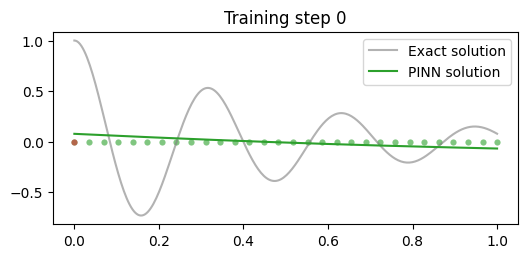

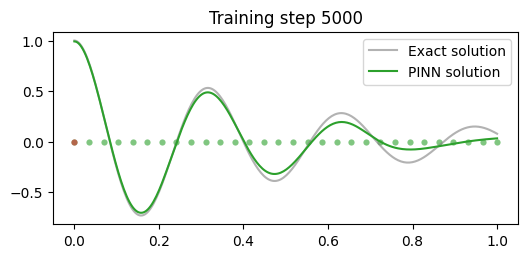

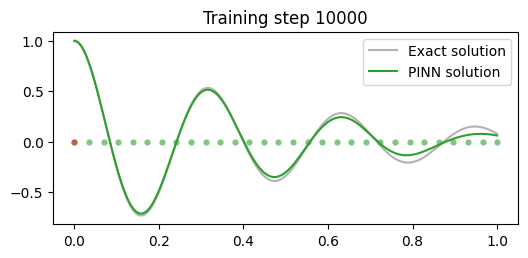

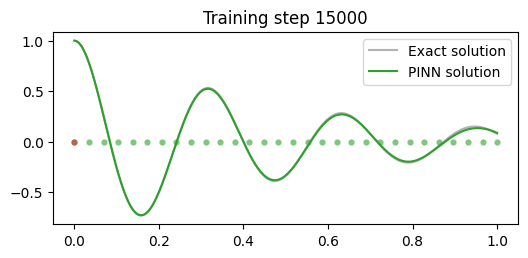

In [6]:
for i in range(15001):
    optim.zero_grad() # reseteamos el gradiente

    # Calculamos la perdida de la condicion de borde
    u = pinn(t_boundary)
    loss1 = torch.mean(torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    loss2 = torch.mean(torch.squeeze(dudt) - 0)**2

    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0] # calculamos la segunda derivada
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## entrenar una PINN para invertir los parámetros subyacentes

La segunda tarea consiste en usar una PINN para **Estimar** parámetros.

Específicamente, nuestras entradas y salidas son:

- Entradas: observaciones con ruido del desplazamiento del oscilador
- Salidas: estimar $\mu$, el coeficiente de fricción

#### Enfoque

De manera similar a lo anterior, la PINN se entrena para aproximar directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

donde $\theta$ son los parámetros libres de la PINN.

La idea clave aquí es también tratar $\mu$ como un **parámetro aprendible** al entrenar la PINN, de modo que simulamos la solución e invertimos para este parámetro.

#### Función de pérdida

La PINN se entrena con una función de pérdida ligeramente diferente:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

#### Notas

Hay dos términos en la función de pérdida aquí. El primero es la **pérdida física**, formada de la misma manera que arriba, que asegura que la solución aprendida por la PINN es consistente con la física conocida.

El segundo término se llama **pérdida de datos**, y asegura que la solución aprendida por la PINN se ajuste a las observaciones de la solución (potencialmente con ruido) que están disponibles.

Nota, hemos eliminado los términos de pérdida de los bordes, ya que no los conocemos (es decir, solo se nos dan las mediciones observadas del sistema).

En esta configuración, los parámetros $\theta$ y $\mu$ de la PINN se aprenden **conjuntamente** durante la optimización.

Nuevamente, la autodiferenciación es nuestra amiga y nos permitirá definir fácilmente este problema.


### Puntos de Entrenamiento

True value of mu: 4


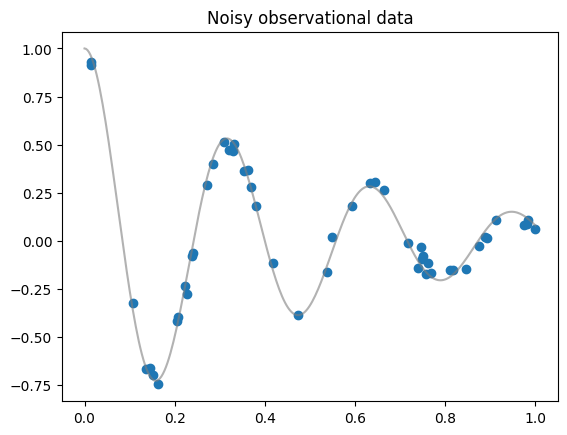

In [7]:
# Creamos data con ruido
d, w0 = 2, 20
print(f"True value of mu: {2*d}")

# Definimos los puntos observacionales para que la red aprenda de los datos
t_obs = torch.rand(50, 1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

# definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
# parametros del problema
_, k = 2*d, w0**2

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

### Hiperparámetros y Modelo

In [11]:
# Creamos un parametro entrenable para mu
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

epochs = 15001
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
lambda1 = 1e4

### Entrenamiento

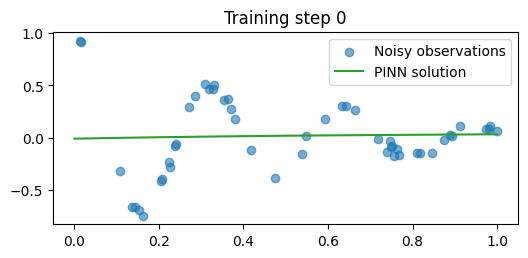

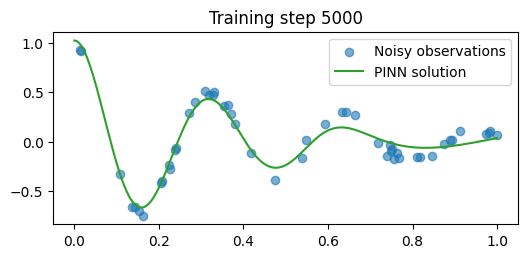

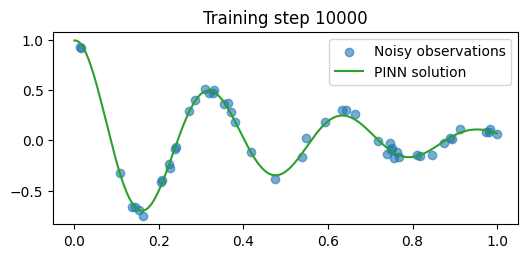

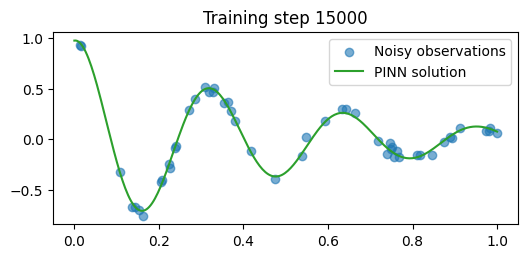

In [12]:
for i in range(epochs):
    # reseteamos el gradiente
    optim.zero_grad()

    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, grad_outputs=torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida en funcion de los datos
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # guardamos el valor de mu
    mus.append(mu.item())

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

### Estimacion de $\mu$

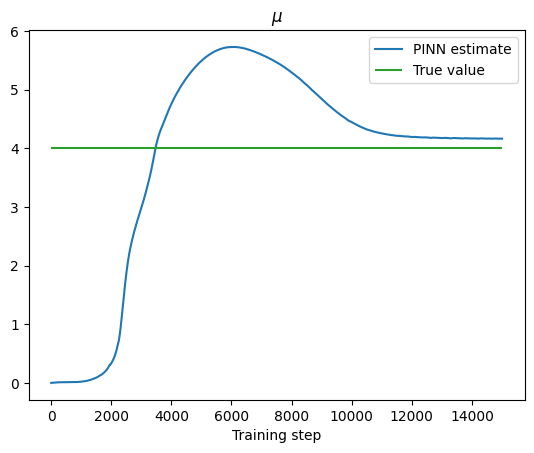

In [13]:
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## cómo escala la PINN a oscilaciones de mayor frecuencia



La tarea final es investigar cómo escala la PINN a oscilaciones de mayor frecuencia y qué se puede hacer para mejorar su convergencia.

Específicamente, volvemos a simular la solución al oscilador armónico e incrementamos su frecuencia, $\omega_0$.


la PINN lucha para converger, incluso si el número de puntos de entrenamiento físico aumenta.

Este es un problema más difícil para la PINN de resolver, en parte debido al **sesgo espectral** de las redes neuronales, así como al hecho de que se requieren más puntos de entrenamiento.

#### Enfoque: formulación alternativa "ansatz"

Para acelerar la convergencia, una forma es **asumir algo** sobre la solución.

Por ejemplo, supongamos que sabemos por nuestra intuición física que la solución es de hecho sinusoidal.

Entonces, en lugar de tener la PINN aproximando directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

En su lugar, usamos la PINN como parte de un ansatz matemático de la solución, es decir

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

donde $\alpha, \beta$ se tratan como parámetros adicionales aprendibles.

Comparando este ansatz con la solución exacta

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

Vemos que ahora la PINN solo necesita aprender la función exponencial, lo cual debería ser un problema mucho más fácil.

¡Una vez más, la autodiferenciación nos permite diferenciar fácilmente a través de este ansatz para entrenar la PINN!


### Puntos de Entrenamiento

In [7]:
# Definimos los parametros A y B para la Ansatz
a = torch.nn.Parameter(70*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# Definimos los puntos para la condicion de borde
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Definimos los puntos del dominio del problema
t_physics = torch.linspace(0,1,70).view(-1,1).requires_grad_(True)

# Parametros del problema
d, w0 = 2, 80 # las oscilaciones (w0) aumentaron
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

### Hiperparámetros y Modelo

In [8]:
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(list(pinn.parameters()) + [a, b], lr=1e-3)
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

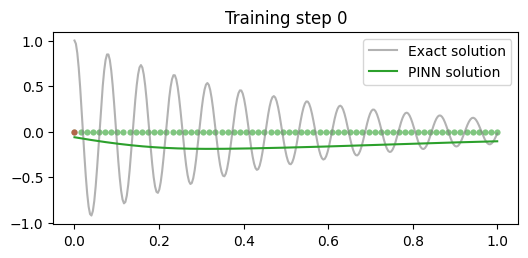

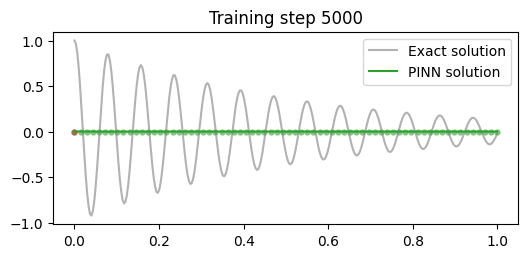

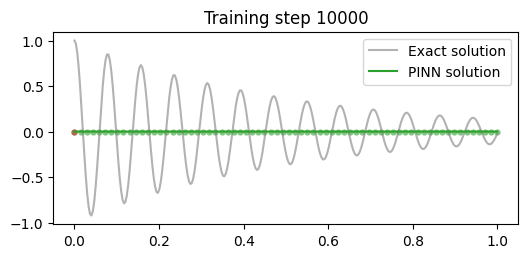

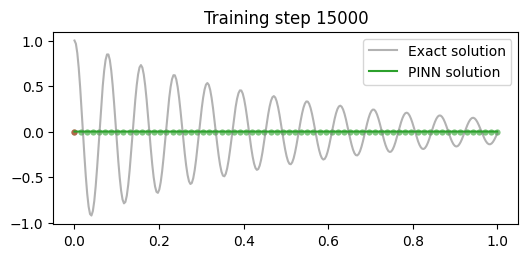

In [10]:
for i in range(15001):
    optim.zero_grad()

    # Predicciones del modelo para condición de borde
    u_boundary = pinn(t_boundary)

    # Derivadas necesarias para la ecuación diferencial
    u_t_physics = pinn(t_physics)
    u_t = torch.autograd.grad(u_t_physics, t_physics, torch.ones_like(u_t_physics), create_graph=True)[0]
    u_tt_physics = pinn(t_physics)
    u_tt = torch.autograd.grad(u_tt_physics, t_physics, torch.ones_like(u_tt_physics), create_graph=True)[0]

    # Pérdida de la condición de borde
    loss1 = torch.mean((u_boundary - exact_solution(d, w0, t_boundary))**2)

    # Pérdida de la ecuación diferencial
    loss2 = torch.mean((u_tt + mu * u_t + k * u_t_physics)**2)

    # Pérdida total
    loss = loss1 + lambda1 * loss2

    loss.backward()
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()